In [1]:
import numpy as np
import cv2

In [2]:
def rect_to_bb(rect):
	# take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

In [3]:
def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords

In [4]:
from collections import OrderedDict

# define a dictionary that maps the indexes of the facial
# landmarks to specific face regions

#For dlib’s 68-point facial landmark detector:
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("inner_mouth", (60, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 36)),
	("jaw", (0, 17))
])

#For dlib’s 5-point facial landmark detector:
FACIAL_LANDMARKS_5_IDXS = OrderedDict([
	("right_eye", (2, 3)),
	("left_eye", (0, 1)),
	("nose", (4))
])

# in order to support legacy code, we'll default the indexes to the
# 68-point model
FACIAL_LANDMARKS_IDXS = FACIAL_LANDMARKS_68_IDXS

In [5]:
class FaceAligner:
    def __init__(self, predictor, desiredLeftEye=(0.35, 0.35),
        desiredFaceWidth=256, desiredFaceHeight=None):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.predictor = predictor # 얼굴 랜드마크 예측 모델
        self.desiredLeftEye = desiredLeftEye # 원하는 출력 왼쪽 눈 위치를 지정
        self.desiredFaceWidth = desiredFaceWidth # 원하는 얼굴을 픽셀 단위로 정의, 기본값 256픽셀
        self.desiredFaceHeight = desiredFaceHeight #  원하는 얼굴 높이 값을 픽셀 단위로 지정
        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth # 정사각형 이미지로 출력


    def align(self, image, gray, rect):
        # image: The RGB input image/ gray: The grayscale input image/ rect: The bounding box rectangle produced by dlib’s HOG face detector
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = self.predictor(gray, rect)
        shape = shape_to_np(shape)
        # extract the left and right eye (x, y)-coordinates
        if (len(shape)==68):
          (lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
          (rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
        else:
          (lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
          (rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]

        leftEyePts = shape[lStart:lEnd]
        rightEyePts = shape[rStart:rEnd]

        # 각 눈의 질량 중심을 계산: 각 눈의 모든 (x, y) 점을 평균하여 각 눈의 중심, 즉 질량 중심을 계산
        leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
        rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

        # 눈 중심 사이의 각도를 계산
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180 # 얼굴 회전의 각도를 계산

        # compute the desired right eye x-coordinate based on the desired x-coordinate of the left eye
        # 왼쪽 눈의 원하는 x좌표를 기반으로 원하는 오른쪽 눈 x 좌표를 계산
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]
        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist


        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = (int((leftEyeCenter[0] + rightEyeCenter[0]) // 2),
              int((leftEyeCenter[1] + rightEyeCenter[1]) // 2))
        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
            flags=cv2.INTER_CUBIC)
        # return the aligned face
        return output

### 정면 사진 테스트

In [6]:
import argparse
import dlib
import cv2
import imutils
from google.colab.patches import cv2_imshow
from collections import OrderedDict
import numpy as np

In [8]:
shape_predictor_path = "/content/drive/MyDrive/Colab Notebooks/DAT 4th/팀프로젝트/shape_predictor_68_face_landmarks.dat"

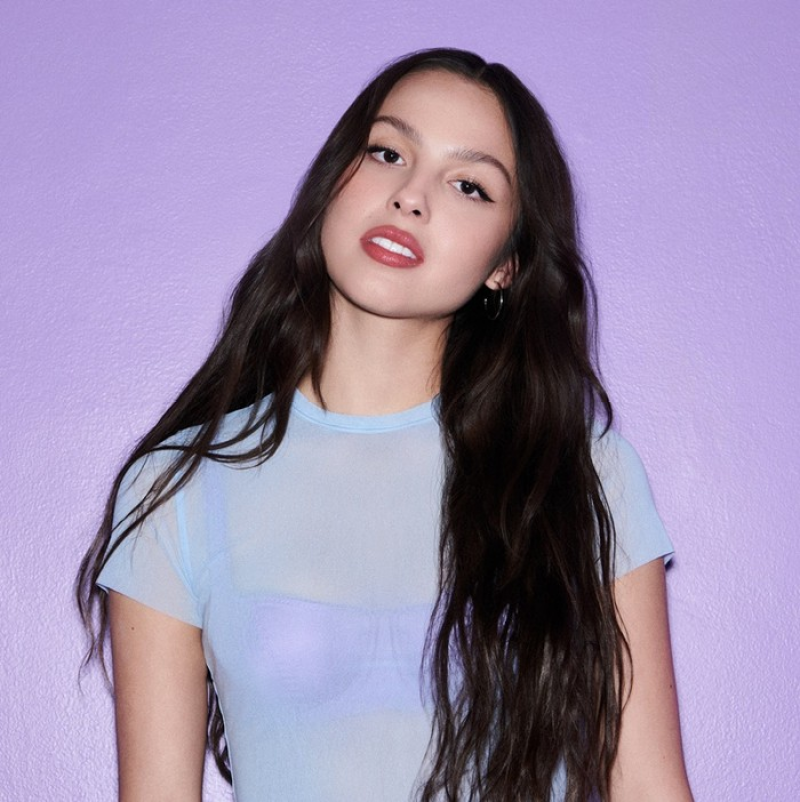

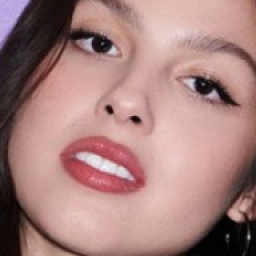

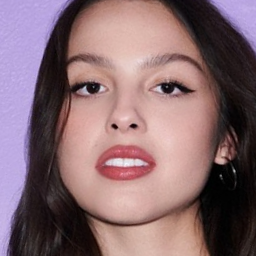

In [ ]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor and the face aligner
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)
fa = FaceAligner(predictor, desiredFaceWidth=256)

# load the input image, resize it, and convert it to grayscale
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/DAT 4th/팀프로젝트/olivia_face.jpg')
image = imutils.resize(image, width=800)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# show the original input image and detect faces in the grayscale
# image
cv2_imshow(image)
rects = detector(gray, 2)

# loop over the face detections
for rect in rects:
	# extract the ROI of the *original* face, then align the face
	# using facial landmarks
	(x, y, w, h) = rect_to_bb(rect)
	faceOrig = imutils.resize(image[y:y + h, x:x + w], width=256)
	faceAligned = fa.align(image, gray, rect)
	# display the output images
	cv2_imshow(faceOrig)
	cv2_imshow(faceAligned)
	cv2.waitKey(0)

### 측면 사진도 테스트

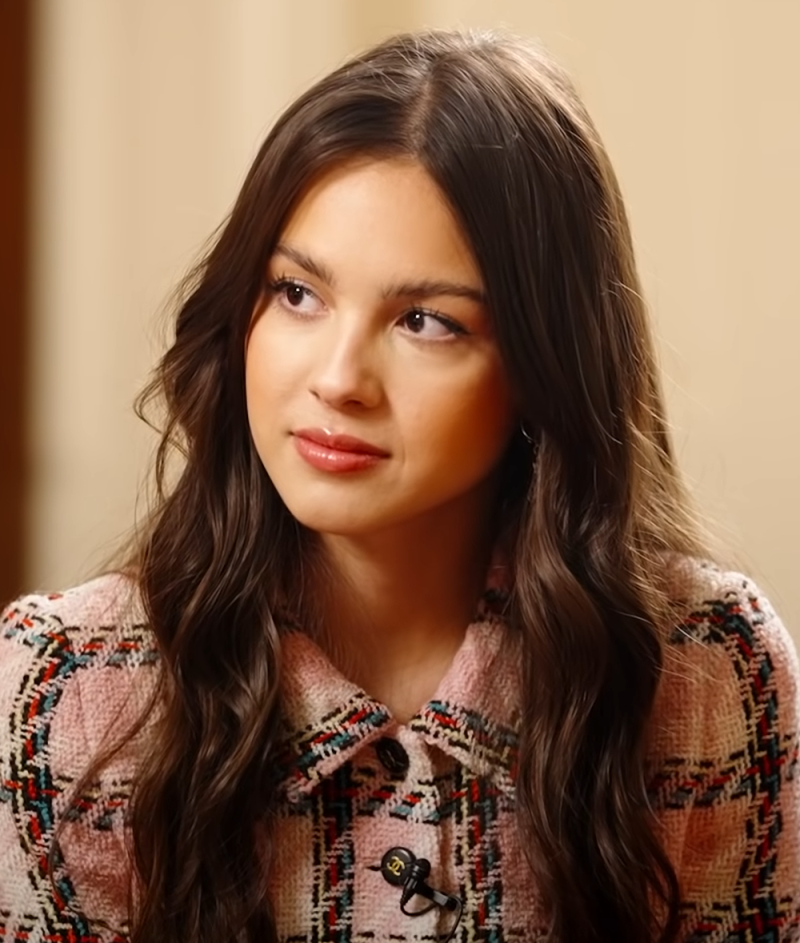

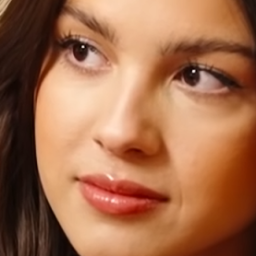

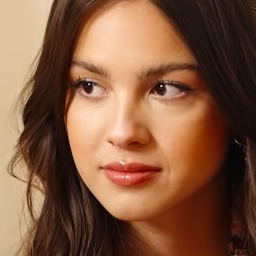

In [ ]:
# load the input image, resize it, and convert it to grayscale
image_side = cv2.imread('/content/drive/MyDrive/Colab Notebooks/DAT 4th/팀프로젝트/olivia_side.png')
image_side = imutils.resize(image_side, width=800)
gray = cv2.cvtColor(image_side, cv2.COLOR_BGR2GRAY)
# show the original input image and detect faces in the grayscale
# image
cv2_imshow(image_side)
rects = detector(gray, 2)

# loop over the face detections
for rect in rects:
	# extract the ROI of the *original* face, then align the face
	# using facial landmarks
	(x, y, w, h) = rect_to_bb(rect)
	faceOrig_side = imutils.resize(image_side[y:y + h, x:x + w], width=256)
	faceAligned_side = fa.align(image_side, gray, rect)
	# display the output images
	cv2_imshow(faceOrig_side)
	cv2_imshow(faceAligned_side)
	cv2.waitKey(0)

### 여러 명 사진 테스트

In [9]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor and the face aligner
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)
fa = FaceAligner(predictor, desiredFaceWidth=256)

# load the input image, resize it, and convert it to grayscale
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/DAT 4th/팀프로젝트/friends.jpg')
image = imutils.resize(image, width=800)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# show the original input image and detect faces in the grayscale
# image
cv2_imshow(image)
rects = detector(gray, 2)

# loop over the face detections
for rect in rects:
	# extract the ROI of the *original* face, then align the face
	# using facial landmarks
	(x, y, w, h) = rect_to_bb(rect)
	faceOrig = imutils.resize(image[y:y + h, x:x + w], width=256)
	faceAligned = fa.align(image, gray, rect)
	# display the output images
	cv2_imshow(faceOrig)
	cv2_imshow(faceAligned)
	cv2.waitKey(0)

Output hidden; open in https://colab.research.google.com to view.